In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import seagul.env
import numpy as np
from numpy import pi

In [7]:
home_path = '/home/sgillen/work/'
checkpoint_path = home_path + 'seagul/seagul/notebooks/sym_rl/data/pendulum2/PPO/PPO_Pendulum-v0_0_sgd_minibatch_size=64_2019-11-18_09-03-19e1yj5g12/checkpoint_150/checkpoint-150'


In [8]:
csv_path = home_path + 'seagul/seagul/notebooks/sym_rl/data/pendulum2/PPO/PPO_Pendulum-v0_0_sgd_minibatch_size=64_2019-11-18_09-03-19e1yj5g12/progress.csv'
df = pd.read_csv(csv_path)
df

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,training_iteration,...,perf/vram_util_percent0,info/learner/default_policy/cur_kl_coeff,info/learner/default_policy/cur_lr,info/learner/default_policy/total_loss,info/learner/default_policy/policy_loss,info/learner/default_policy/vf_loss,info/learner/default_policy/vf_explained_var,info/learner/default_policy/kl,info/learner/default_policy/entropy,info/learner/default_policy/entropy_coeff
0,-875.611680,-1733.214055,-1274.476397,200.0,20,4000,False,4000,20,1,...,0.042798,1.000000,0.0003,6.178935,-0.001348,6.179302,0.761864,0.000981,1.424876,0.0
1,-747.680084,-1807.060469,-1268.155204,200.0,20,4000,False,8000,40,2,...,0.042798,0.500000,0.0003,2.519063,-0.002395,2.520654,0.949991,0.001608,1.424001,0.0
2,-629.279752,-1807.060469,-1224.208445,200.0,20,4000,False,12000,60,3,...,0.042798,0.250000,0.0003,2.725791,-0.015438,2.737488,0.970789,0.014962,1.417285,0.0
3,-629.279752,-1807.060469,-1224.816201,200.0,20,4000,False,16000,80,4,...,0.042798,0.250000,0.0003,3.324630,-0.010050,3.332848,0.977790,0.007325,1.412261,0.0
4,-629.279752,-1807.060469,-1222.645658,200.0,20,4000,False,20000,100,5,...,0.042798,0.250000,0.0003,4.258447,-0.008555,4.264928,0.976944,0.008289,1.406514,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.274842,-400.366415,-152.303741,200.0,20,4000,False,584000,2920,146,...,0.042798,0.949219,0.0003,0.009944,-0.018029,0.021720,0.999957,0.006588,0.459583,0.0
146,-0.205995,-400.366415,-163.118269,200.0,20,4000,False,588000,2940,147,...,0.042798,0.949219,0.0003,0.025567,-0.017540,0.034536,0.999953,0.009030,0.483547,0.0
147,-0.205995,-400.366415,-163.131551,200.0,20,4000,False,592000,2960,148,...,0.042798,0.949219,0.0003,0.028969,-0.005581,0.020756,0.999961,0.014532,0.463551,0.0
148,-0.205995,-399.131891,-157.872236,200.0,20,4000,False,596000,2980,149,...,0.042798,0.949219,0.0003,0.004941,-0.017751,0.014176,0.999970,0.008971,0.448345,0.0


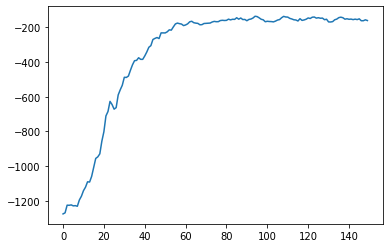

In [9]:
plt.plot(df['episode_reward_mean'])

In [16]:
ray.shutdown()
ray.init()

expr_path = "seagul/seagul/notebooks/sym_rl/data/pendulum2/PPO/experiment_state-2019-11-18_09-03-19.json"

expr_data = json.load(open('/home/sgillen/work/' + expr_path))
config = expr_data['checkpoints'][-1]['config']
env_name = config['env']

#log_path = expr_data['checkpoints'][-1]['logdir']
#csv_path = log_path + '/path/progress.csv'

trainer = ppo.PPOTrainer(config)#, config['env_name'])
trainer.restore(checkpoint_path)

2019-11-18 09:28:31,041	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-11-18 09:28:31,044	INFO resource_spec.py:205 -- Starting Ray with 4.64 GiB memory available for workers and up to 2.34 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-18 09:28:31,470	INFO trainer.py:345 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2019-11-18 09:28:34,430	INFO rollout_worker.py:768 -- Built policy map: {'default_policy': <ray.rllib.policy.tf_policy_template.PPOTFPolicy object at 0x7f78c29bd630>}
2019-11-18 09:28:34,431	INFO rollout_worker.py:769 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f78c29bd4e0>}
2019-11-18 09:28:34,432	INFO rollout_worker.py:370 -- Built filter map: {'defa

-123.63470980472208


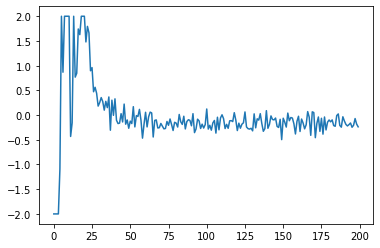

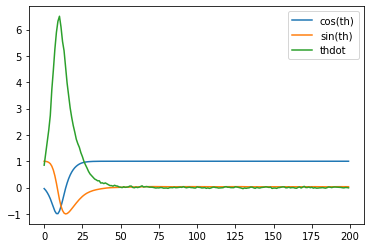

In [17]:
import gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

env = gym.make(env_name)
obs = env.reset()

action_hist = []
state_hist  = []
reward_hist = []

done = False
while not done:
    actions = trainer.compute_action(obs.flatten())
    obs, reward, done, _ = env.step(np.asarray(actions))
    #env.render()
    action_hist.append(np.copy(np.clip(actions, -10, 10)))
    state_hist.append(np.copy(obs))
    reward_hist.append(np.copy(reward))
    if done:
        break


print(sum(reward_hist))
plt.plot(action_hist)
plt.figure()
plt.plot(state_hist)
plt.legend(['cos(th)', 'sin(th)', 'thdot'])

In [82]:
# Reminder that the bahavior logits that come out are the mean and logstd (not log mean, despite the name logit)
trainer.compute_action(obs, full_fetch=True)

(array([2.], dtype=float32),
 [],
 {'action_prob': 0.071813315,
  'action_logp': -2.6336854,
  'vf_preds': -62.79916,
  'behaviour_logits': array([1.7688665, 0.29777  ], dtype=float32)})

In [87]:
th_vals = np.linspace(-pi, pi, 200)
thdot_vals= np.linspace(-8, 8, 200)
actions = np.zeros((th_vals.size, thdot_vals.size))

vf_preds = np.zeros((th_vals.size, thdot_vals.size))
act_probs = np.zeros((th_vals.size, thdot_vals.size))
act_means = np.zeros((th_vals.size, thdot_vals.size))
act_lgstd = np.zeros((th_vals.size, thdot_vals.size))

for th_i, th in enumerate(th_vals):
    for thdot_i, thdot in enumerate(thdot_vals):
        obs = np.array([np.cos(th), np.sin(th), thdot])
        actions[th_i, thdot_i],_, out_dict = trainer.compute_action(obs.flatten(),full_fetch=True)
        
        vf_preds[th_i,  thdot_i]     = out_dict['vf_preds']
        act_probs[th_i, thdot_i]  = out_dict['action_prob']
        act_means[th_i, thdot_i]  = out_dict['behaviour_logits'][0]
        act_lgstd[th_i, thdot_i]  = out_dict['behaviour_logits'][1]
        

In [89]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 18
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x,y = np.meshgrid(th_vals, thdot_vals)

Text(0.5, 1.0, 'Sampled Actions')

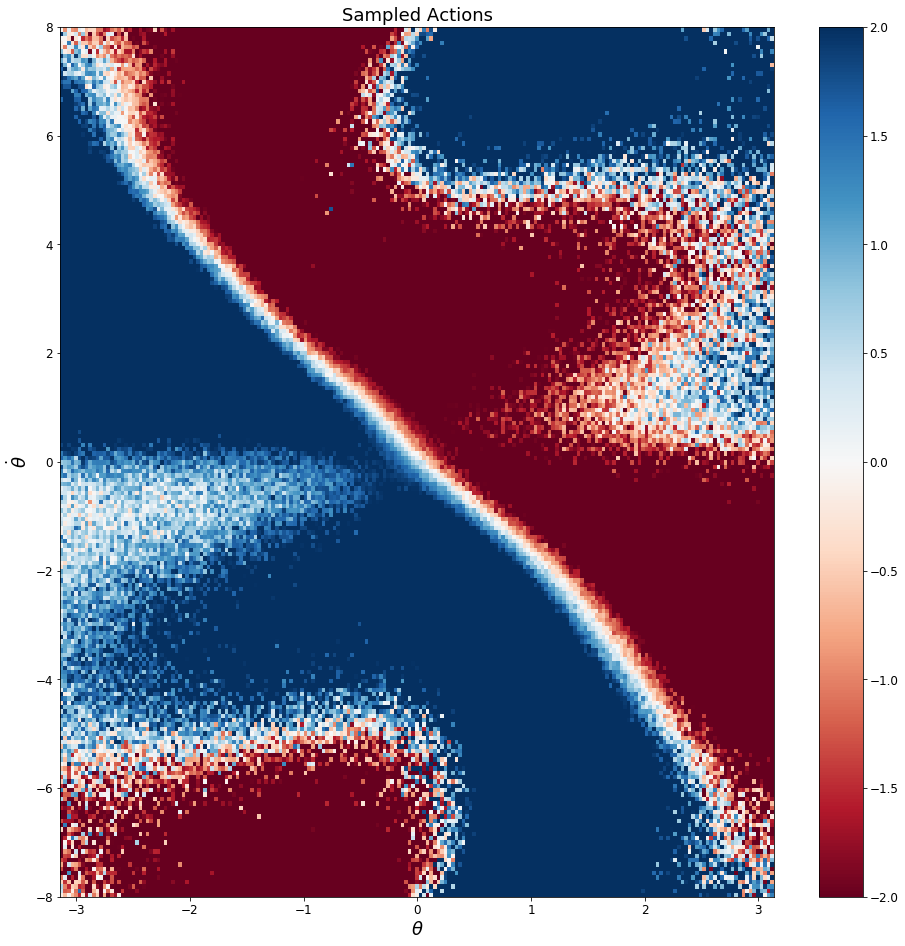

In [91]:
z = actions
z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()


fig, ax = plt.subplots(1,1, figsize=(16,16))
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.title('Sampled Actions')

Text(0.5, 1.0, 'Action Means')

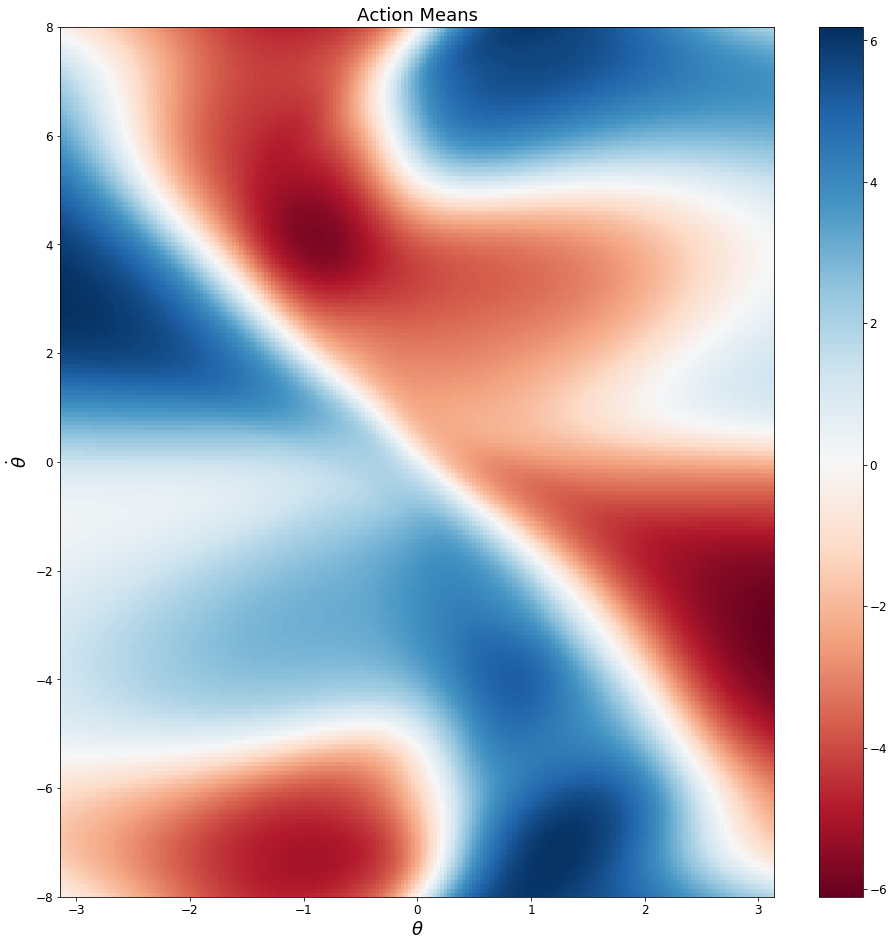

In [92]:
z = act_means
z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()


fig, ax = plt.subplots(1,1, figsize=(16,16))
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.title('Action Means')

Text(0.5, 1.0, 'Action Stds')

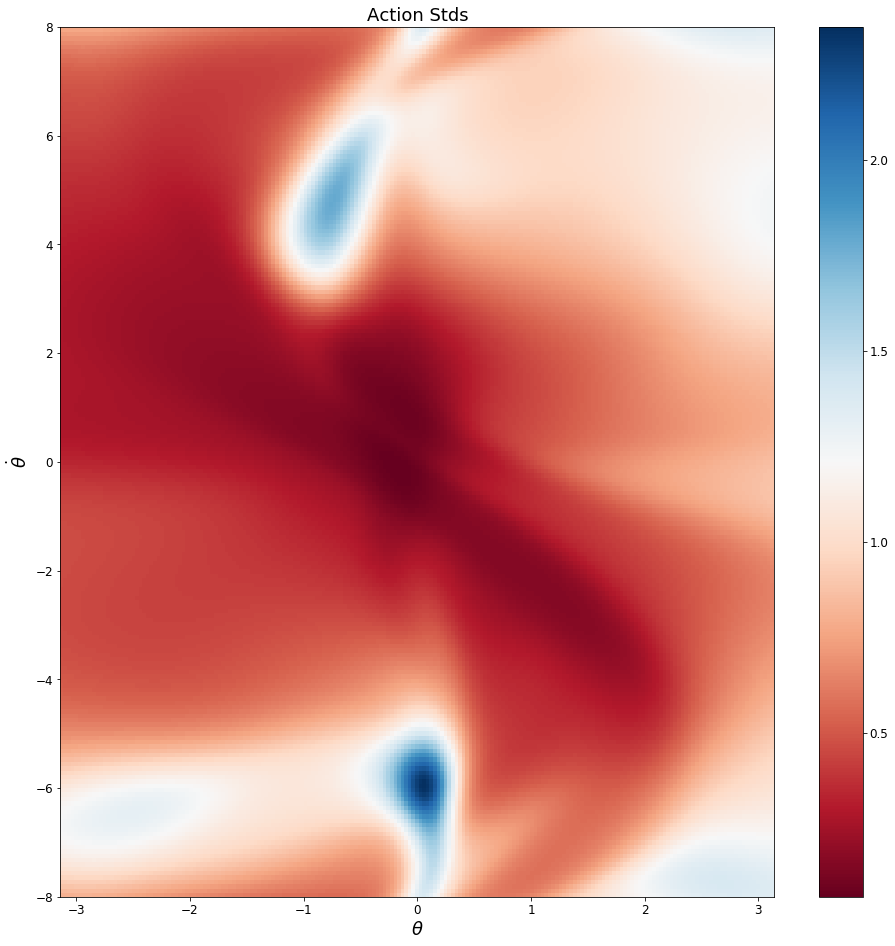

In [95]:
z = np.exp(act_lgstd)
z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()


fig, ax = plt.subplots(1,1, figsize=(16,16))
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.title('Action Stds')

Text(0.5, 1.0, 'VF Prediction')

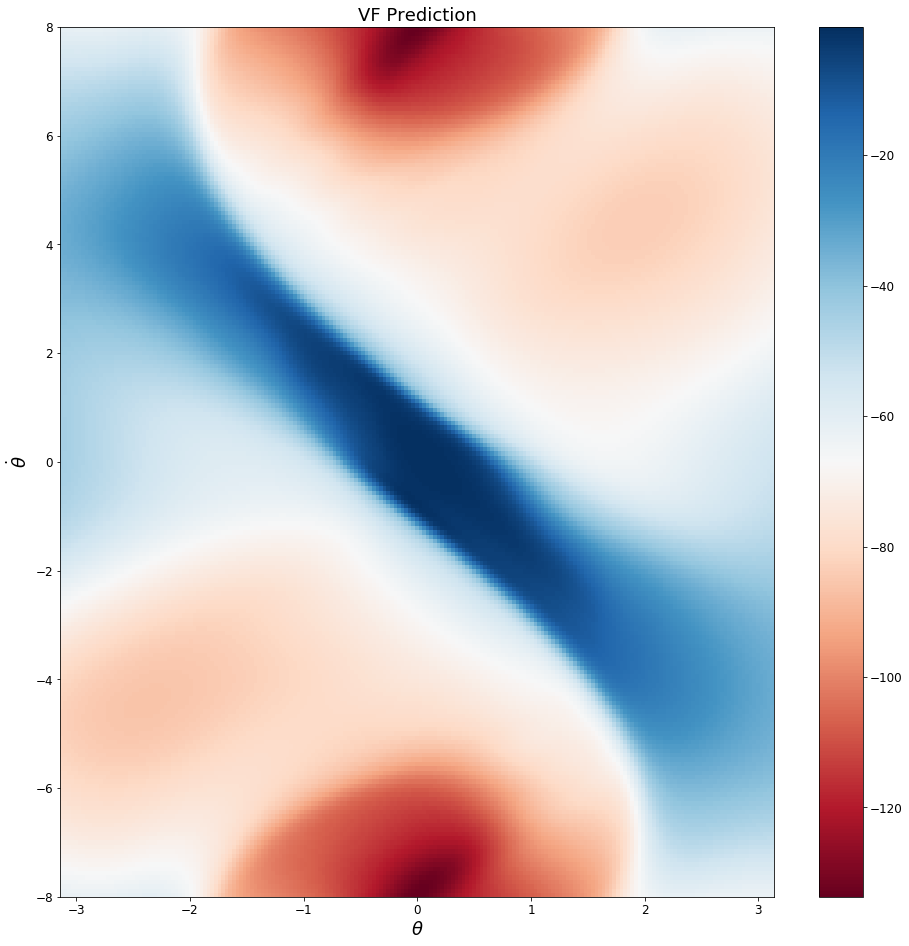

In [98]:
z = vf_preds
z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()


fig, ax = plt.subplots(1,1, figsize=(16,16))
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.title('VF Prediction')